In [1]:
import os
import io
import praw
import nltk
import time
import math
import stanza
import string
import time

import numpy as np
import pandas as pd
import datetime as dt

#use scipy v1.8.0, networkx v2.6
import networkx as nx 
from heapq import nlargest
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize
from string import punctuation

<h3> 3. Evaluating the results of Sentiment Analysis</h3>

In [2]:
#load
df = pd.read_csv('predict_output_xgb.csv')
df = df.loc[df['pred_sentiment'] != 'neutral']

In [3]:
#get month and year of creation for splitting of data later
df['created'] = pd.to_datetime(df['created'], format = '%d/%m/%Y %H:%M')
df['day'] = df['created'].dt.day
df['month'] = df['created'].dt.month
df['year'] = df['created'].dt.year
df = df.rename(columns={'pred_sentiment': 'Sentiment'})

In [4]:
#group and form pivot table for visualization
grouped = df.groupby(['year', 'month', 'Sentiment']).size().reset_index()
grouped_pivot = grouped.pivot_table(index = ['year', 'month'], columns = 'Sentiment', values ='Sentiment', fill_value = 0)
grouped_pivot_normalized = grouped_pivot.div(grouped_pivot.sum(axis = 1), axis = 0)

<h3>3.1. Distribution of Posts by Sentiments by Month</h3>

A look at the distribution of the raw number of posts and comments over time revealed that there's been a steady uptick in activity within the game's subreddit. There are also noticeable increases in activity after each teaser/trailer is dropped by the official youtube channel. As such, we can conclude that the company's marketing efforts were very effective in generating hype leading up to the official launch.

As seen in the normalized graph, the proportion of positive and negative posts/comments remained rather consistent over the months leading up to the release of the game. This is an indication that the game has indeed lived up to the players' expectations.

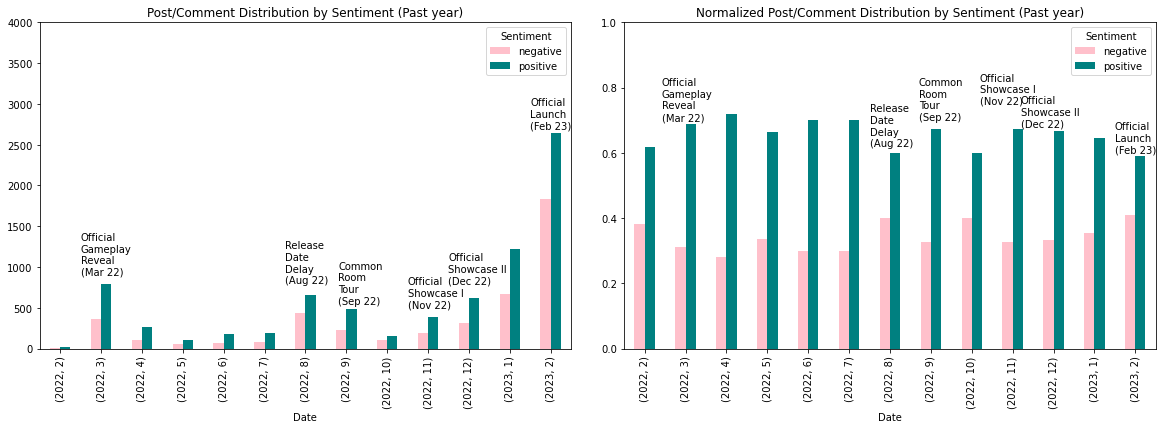

In [5]:
#by proportion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))

#raw values
cols = ['pink', 'teal']
grouped_pivot.plot(
    kind = 'bar', stacked = False, 
    figsize = (20, 10), color = cols,
    ax = ax1, xlabel = 'Date',
    title = 'Post/Comment Distribution by Sentiment (Past year)'
)

ax1.set_ylim(top = 4000)
ax1.text(0.5, 900, 'Official\nGameplay\nReveal\n(Mar 22)')
ax1.text(5.5, 800, 'Release\nDate\nDelay\n(Aug 22)')
ax1.text(6.8, 550, 'Common\nRoom\nTour\n(Sep 22)')
ax1.text(8.5, 500, 'Official\nShowcase I\n(Nov 22)')
ax1.text(9.5, 800, 'Official\nShowcase II\n(Dec 22)')
ax1.text(11.5, 2700, 'Official\nLaunch\n(Feb 23)')

#normalized
grouped_pivot_normalized.plot(
    kind = 'bar', stacked = False, 
    figsize = (20, 6), color = cols, 
    ax = ax2, xlabel = 'Date',
    title = 'Normalized Post/Comment Distribution by Sentiment (Past year)'
)

ax2.set_ylim(top = 1)
ax2.text(0.42, 0.7, 'Official\nGameplay\nReveal\n(Mar 22)')
ax2.text(5.5, 0.62, 'Release\nDate\nDelay\n(Aug 22)')
ax2.text(6.7, 0.7, 'Common\nRoom\nTour\n(Sep 22)')
ax2.text(8.2, 0.75, 'Official\nShowcase I\n(Nov 22)')
ax2.text(9.2, 0.68, 'Official\nShowcase II\n(Dec 22)')
ax2.text(11.5, 0.6, 'Official\nLaunch\n(Feb 23)')

#reduce space
plt.subplots_adjust(wspace=0.1)

<h3>3.2. Post-launch Sentiments</h3>

We'll now shift our focus over to the post-launch discussions. The post-launch period can be further divided into early access and official launch; players who preordered the deluxe or collector's edition of the game are entitled to accessing the game 3 days ahead of its official launch, which is set on the 10th of February. These two copies are significantly more expensive than the base edition.

Based on the chart presented below, it is evident that the game had an exceptional initial response. On the first day of early access, the positivity rate of posts and comments was as high as 70%. However, over the subsequent three days, the proportion of positive feedback decreased significantly. In fact, on the 9th of February, the proportion of positive comments barely exceeded 50%. We hypothesized that the initial spike in positive posts/comments was due to the players experiencing a great sense of excitement as they explored the game, which they've been eagerly anticipating for a long time. As they progressed through the game, issues began to arise, and the subreddit rapidly became inundated with complaints.

The uptick in the proportion of positive posts/comments from the 10th onwards is likely due to the release of the day-1 patch, which resolved a number of these issues, as well as the infusion of positive comments from new players whom have also been awash with the initial sense of excitement and wonder. However, the proportion of negative comments remained high beyond the 10th. Over the next 3 days, the proportion of negative comments rose again, possibly due to the players discovering more issues as they played on. This will be discussed in greater detail in the next section.

Text(2.75, 0.62, 'Official Release\n(Day 1 Patch)')

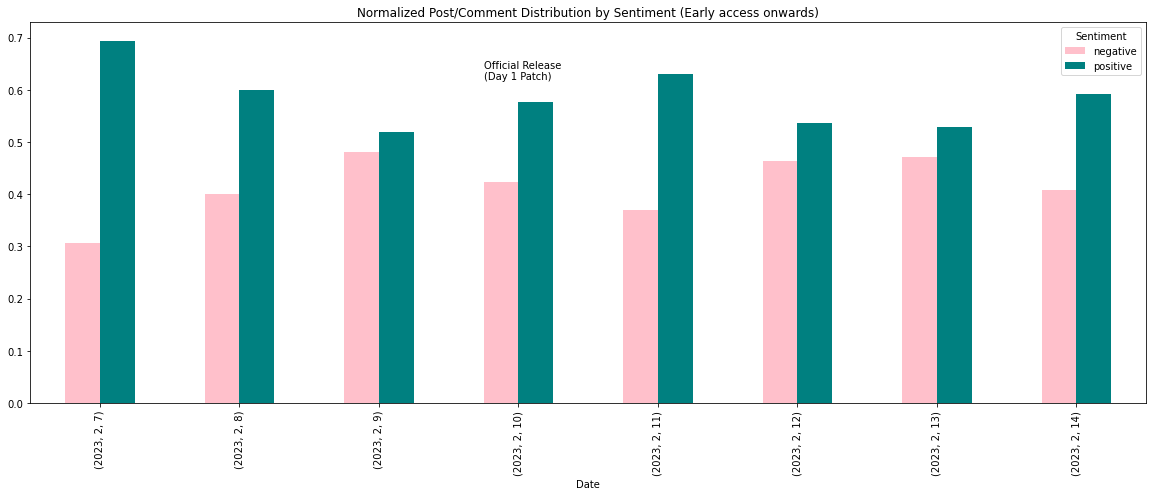

In [7]:
pr_df = df.loc[pd.to_datetime(df['created'])>=dt.datetime(2023,2,7,6,0,0)].reset_index(drop = True)

#group and form pivot table for visualization
grouped2 = pr_df.groupby(['year', 'month', 'day', 'Sentiment']).size().reset_index()

#group and form pivot table for visualization
grouped_pivot2 = grouped2.pivot_table(index = ['year', 'month', 'day'], columns = 'Sentiment', values ='Sentiment', fill_value = 0)
grouped_pivot_normalized2 = grouped_pivot2.div(grouped_pivot2.sum(axis = 1), axis = 0)

#by proportion
ax3 = grouped_pivot_normalized2.plot(kind = 'bar', stacked = False, figsize = (20, 7), color = cols)
plt.xlabel('Date')
plt.title('Normalized Post/Comment Distribution by Sentiment (Early access onwards)')

ax3.text(2.75, 0.62, 'Official Release\n(Day 1 Patch)')